# Neural Networks Learning

To implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition.

## Model representation
The model has 3 layers - an input layer, a hidden layer and an output layer. The inputs are pixcel values of 20x20 digit images which gives us 400 input layer units (not counting the extra bias unit which always outputs +1). 
There are weights from files (Theta1, Theta2) which are already trained to be used in the exercise.

- input units: 400
- hidden units: 25
- output units: 10 (classifier for each digit)
- $\Theta^{(1)}$ has size 25 x 401
- $\Theta^{(2)}$ has size 10 x 26

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from scipy.optimize import fmin_cg


In [2]:
mat =  scipy.io.loadmat('datasets/ex4data1.mat')
X, y = mat['X'], mat['y']
m = X.shape[0]
print('X size: {}'.format(X.shape))
print('y size: {}'.format(y.shape))

X size: (5000, 400)
y size: (5000, 1)


### Neural Networks
#### Visualizing the data

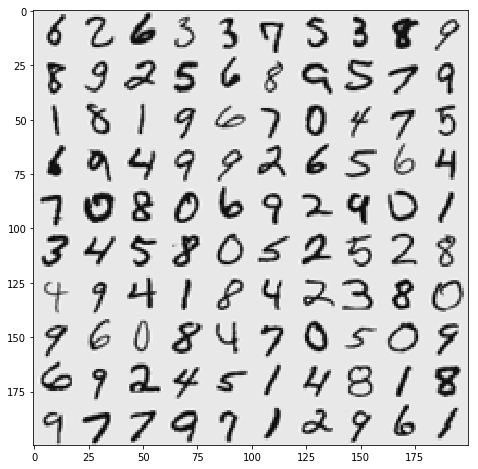

In [3]:
width, height = 20, 20
nrows, ncols = 10, 10

idx = np.random.choice(m, nrows * ncols)
digits_im = np.zeros((height*nrows, width*ncols))
for j in np.arange(nrows):
    for i in np.arange(ncols):
        x_slice = slice(i*width,(i+1)*width)
        y_slice = slice(j*height,(j+1)*height)
        n = idx[j*ncols + i]
        digits_im[y_slice, x_slice] = X[n].reshape(height, width).T
plt.figure(figsize=(8,8))
plt.imshow(digits_im, cmap=plt.cm.gray_r);

#### 1.2 Model representation

In [4]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

mat = scipy.io.loadmat('datasets/ex4weights.mat')
Theta1 = mat['Theta1']
Theta2 = mat['Theta2']
print('Theta1 size: {}'.format(Theta1.shape))
print('Theta2 size: {}'.format(Theta2.shape))

Theta1 size: (25, 401)
Theta2 size: (10, 26)


In [5]:
# Utility functions

def unrollParams(t1, t2):
     return np.append(t1.flatten(), t2.flatten())

def extractParams(params):    
    t1 = params[:(hidden_layer_size * (input_layer_size+1))] \
                .reshape(hidden_layer_size, input_layer_size+1)
    t2 = params[hidden_layer_size * (input_layer_size + 1):] \
                .reshape(num_labels, hidden_layer_size + 1)
    return (t1, t2)

#### 1.3 Feedforward and cost function

####  Cost Function

In [6]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels,
                  X, y, lambd):
    
    # Unpack theta1 and theta2
    theta1 = nn_params[:(hidden_layer_size * (input_layer_size+1))] \
                .reshape(hidden_layer_size, input_layer_size+1)
    theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):] \
                .reshape(num_labels, hidden_layer_size + 1)
    m = X.shape[0]
    
    # Create dummy variables for y (from label {1:10} to var in {0,1} for each label)
    yt = np.array([ list(range(1,num_labels+1)) for i in range(m)])
    yt = (yt == y).astype(float)    # matrix (5000,10)
    
    # Initialization
    J = 0

    # Feedforward Propagation
    a1 = np.insert(X, 0, 1, 1) # (5000,400) -> (5000,401)

    # compute activations for the hidden layer (l=2)
    z2 = a1 @ theta1.T # (5000,401)x(401,25) -> (5000,25)
    a2 = sigmoid(z2)
    
    # add bias units to a2
    a2 = np.insert(a2, 0, 1, 1) # (5000,25) -> (5000,26)
    
    # compute output layer - a3 or h(x)
    z3 = a2 @ theta2.T # (5000,26)x(26,10) -> (5000,10)
    h = sigmoid(z3)
    
    # Compute Cost and Regularization term
    J = 1/m * np.sum(-yt*np.log(h) - (1-yt)*np.log(1-h), axis=None) # sum along all axes

    reg_term = lambd/(2*m) * \
            (np.sum(theta1[:,1:]**2, axis=None) + np.sum(theta2[:,1:]**2, axis=None))

    return J + reg_term

#### Testing Cost Function

In [7]:
print('Feedforward Using Neural Network ...')

nn_params = unrollParams(Theta1, Theta2)

lambd = 0

J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                  num_labels, X, y, lambd)

print('Cost at parameters (loaded from ex4weights): {}'.format(J))
print('Expected value (approx): 0.287629')

Feedforward Using Neural Network ...
Cost at parameters (loaded from ex4weights): 0.2876291651613189
Expected value (approx): 0.287629


#### Testing Cost Function with Regularization

In [8]:
lambd = 3

J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                  num_labels, X, y, lambd)
print('Cost with regularization (lambda = 3)')
print('Cost at parameters (loaded from ex4weights): {}'.format(J))
print('Expected value (approx): 0.576051')

Cost with regularization (lambda = 3)
Cost at parameters (loaded from ex4weights): 0.5760512469501331
Expected value (approx): 0.576051


### Backpropagation

#### Sigmoid gradient

In [9]:
def sigmoidGradient(z):
    g = sigmoid(z)
    return g * (1-g)

print('Evaluating sigmoid gradient...')

g = sigmoidGradient(np.array([-1, -0.5, 0, 0.5, 1]))
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n{}'.format(g))

Evaluating sigmoid gradient...
Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


#### Random initialization
Note: one effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice of $\epsilon_{init}$ is $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in}+L_{out}}}$ where $L_{in} = s_l$ and $L_{out} = s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{(l)}$

In [10]:
def randInitializeWeights(in_layer_size, out_layer_size):
    EPSILON_INIT = 0.12
    return np.random.uniform(size=(out_layer_size, 1+in_layer_size)) * \
                2*EPSILON_INIT - EPSILON_INIT

In [11]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

initial_nn_params = unrollParams(initial_Theta1, initial_Theta2)
initial_nn_params.shape

(10285,)

#### Backpropagation

In [12]:
def nnGradientFunction(nn_params, input_layer_size, hidden_layer_size, num_labels,
                  X, y, lambd):
    
    # Unpack theta1 and theta2
    theta1 = nn_params[:(hidden_layer_size * (input_layer_size+1))] \
                .reshape(hidden_layer_size, input_layer_size+1)
    theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):] \
                .reshape(num_labels, hidden_layer_size + 1)
    m = X.shape[0]
    
    # Create dummy variables for y (from label {1:10} to var in {0,1} for each label)
    yt = np.array([ list(range(1,num_labels+1)) for i in range(m)])
    yt = (yt == y).astype(float)    # (5000,10)
    
    # Initialization
    Theta1_grad = np.zeros(theta1.shape)
    Theta2_grad = np.zeros(theta2.shape)

    Delta1 = np.zeros(theta1.shape)
    Delta2 = np.zeros(theta2.shape)

    # Feedforward Propagation
    # ---------------------------------------------------
    a1 = np.insert(X, 0, 1, 1) # (5000,400) -> (5000,401)

    # compute activations for the hidden layer (l=2)
    z2 = a1 @ theta1.T # (5000,401)x(401,25) -> (5000,25)
    a2 = sigmoid(z2)
    
    # add bias units to a2
    a2 = np.insert(a2, 0, 1, 1) # (5000,25) -> (5000,26)
    
    # compute output layer - a3 or h(x)
    z3 = a2 @ theta2.T # (5000,26)x(26,10) -> (5000,10)
    a3 = sigmoid(z3)   # (5000,10)
    
    # Backpropagation
    # ---------------------------------------------------
    delta_3 = a3 - yt  # (5000,10)
    delta_2 = (delta_3 @ theta2)[:,1:] * sigmoidGradient(z2)
    # (5000,10)x(10,26) -> (5000,26)->(5000,25) * (5000,25)
    
    # For each training example
    for t in np.arange(m):
        # Accumulate the gradients
        Delta1 = Delta1 + (delta_2[t,:].reshape(-1,1) @ a1[t,:].reshape(1,-1)) # (25,401) + (25,1)x(1,401)
        Delta2 = Delta2 + (delta_3[t,:].reshape(-1,1) @ a2[t,:].reshape(1,-1)) # (10,26) + (10,1)x(1,26)

    # Gradients 
    Theta1_grad = (1/float(m)) * Delta1
    Theta2_grad = (1/float(m)) * Delta2

    # Regularization - exclude bias terms (1st column)
    Theta1_grad[:,1:] = Theta1_grad[:,1:] + (lambd/float(m) * theta1[:,1:])
    Theta2_grad[:,1:] = Theta2_grad[:,1:] + (lambd/float(m) * theta2[:,1:])

    grad = unrollParams(Theta1_grad, Theta2_grad)
    return grad

#### Gradient checking

In [13]:
num_input = 3
num_hidden = 5
num_output = 3
num_m = 5

def generateTestMatrix(m, n):
    return np.sin(np.arange(1, m*n+1)).reshape(m,n) / 10

def checkNNGradients(lambd):
    t1 = generateTestMatrix(num_hidden, num_input+1)
    t2 = generateTestMatrix(num_output, num_hidden+1)

    test_X = generateTestMatrix(num_m, num_input)
    test_y = np.arange(1, num_m+1)%num_output + 1
    test_y = test_y.reshape(-1,1)

    test_nn_params = unrollParams(t1, t2)

    J = lambda params: nnCostFunction(params, 
                            num_input, num_hidden, num_output ,test_X, test_y, lambd)

    numgrad = np.zeros(test_nn_params.size)
    perturb = np.zeros(test_nn_params.size)
    e = 1e-4
    # Compute Numerical Gradients
    for p in np.arange(test_nn_params.size):
        # Set perturbation vector
        perturb[p] = e
        loss1 = J(test_nn_params - perturb)
        loss2 = J(test_nn_params + perturb)
        numgrad[p] = (loss2-loss1)/(2*e)
        perturb[p] = 0
    
    # Actual gradient computation
    grad = nnGradientFunction(test_nn_params, num_input, num_hidden, num_output ,test_X, test_y, lambd)
    print('Comparing computed Gradients with numerical Gradients (lambda ={})...'.format(lambd))
    print('Visually inspect the two gradients side-by-side\n[Numerical Gradient, Gradient, Diff]')
    print(np.vstack([numgrad, grad, numgrad-grad]).T)
    
    
checkNNGradients(lambd=0)

Comparing computed Gradients with numerical Gradients (lambda =0)...
Visually inspect the two gradients side-by-side
[Numerical Gradient, Gradient, Diff]
[[ 1.23162247e-02  1.23162247e-02 -9.61520447e-12]
 [ 1.73828183e-04  1.73828184e-04 -9.09418808e-13]
 [ 2.61455146e-04  2.61455144e-04  2.69162253e-12]
 [ 1.08701448e-04  1.08701450e-04 -2.36597113e-12]
 [ 3.92471369e-03  3.92471369e-03  4.77309164e-14]
 [ 1.90101250e-04  1.90101252e-04 -1.29150556e-12]
 [ 2.22272334e-04  2.22272331e-04  2.51644078e-12]
 [ 5.00872543e-05  5.00872547e-05 -3.91490219e-13]
 [-8.08459407e-03 -8.08459407e-03  6.55514532e-12]
 [ 3.13170623e-05  3.13170587e-05  3.58724922e-12]
 [-2.17840346e-05 -2.17840341e-05 -4.38002323e-13]
 [-5.48569856e-05 -5.48569864e-05  8.20789536e-13]
 [-1.26669105e-02 -1.26669105e-02  7.17646602e-12]
 [-1.56130209e-04 -1.56130210e-04  1.57816344e-12]
 [-2.45506162e-04 -2.45506163e-04  7.03879121e-13]
 [-1.09164882e-04 -1.09164881e-04 -2.19123087e-13]
 [-5.59342546e-03 -5.59342547e

In [14]:
checkNNGradients(lambd=3)

Comparing computed Gradients with numerical Gradients (lambda =3)...
Visually inspect the two gradients side-by-side
[Numerical Gradient, Gradient, Diff]
[[ 1.23162247e-02  1.23162247e-02 -9.61520447e-12]
 [ 5.47316738e-02  5.47316738e-02 -3.02230463e-13]
 [ 8.72865563e-03  8.72865563e-03  2.07514735e-12]
 [-4.52994483e-02 -4.52994483e-02 -1.98609185e-12]
 [ 3.92471369e-03  3.92471369e-03  4.77309164e-14]
 [-1.65748286e-02 -1.65748286e-02 -2.57638008e-12]
 [ 3.96414683e-02  3.96414683e-02  2.37413561e-12]
 [ 5.94115821e-02  5.94115821e-02 -3.33615080e-13]
 [-8.08459407e-03 -8.08459407e-03  6.55514532e-12]
 [-3.26099496e-02 -3.26099496e-02  2.91732610e-12]
 [-6.00211964e-02 -6.00211964e-02 -1.38088846e-12]
 [-3.22492321e-02 -3.22492321e-02 -5.48894263e-13]
 [-1.26669105e-02 -1.26669105e-02  7.17646602e-12]
 [ 5.92803111e-02  5.92803111e-02  1.87271726e-12]
 [ 3.87717642e-02  3.87717642e-02  1.39013800e-12]
 [-1.73833639e-02 -1.73833639e-02 -4.20944529e-13]
 [-5.59342546e-03 -5.59342547e

#### Train Neural Network (Max iterations: 50)

In [15]:
lambd = 1

result = fmin_cg(f = nnCostFunction,
                     x0 = initial_nn_params,
                     args = (input_layer_size, hidden_layer_size, num_labels,
                              X, y, lambd),
                     fprime = nnGradientFunction,
                     maxiter=50, disp=True)
result

         Current function value: 0.457833
         Iterations: 50
         Function evaluations: 104
         Gradient evaluations: 104


array([-1.06708113, -0.06071117,  0.01309968, ...,  0.35384783,
       -0.79428152, -1.96636755])

##### Predict (Feedforward propagation)

In [16]:
# unpack Trained Thetas
trained_theta1, trained_theta2 = extractParams(result)

# Feedforward Propagation
a1 = np.insert(X, 0, 1, 1) # (5000,400) -> (5000,401)

# compute activations for the hidden layer (l=2)
z2 = a1 @ trained_theta1.T # (5000,401)x(401,25) -> (5000,25)
a2 = sigmoid(z2)

# add bias units to a2
a2 = np.insert(a2, 0, 1, 1) # (5000,25) -> (5000,26)

# compute output layer - a3 or h(x)
z3 = a2 @ trained_theta2.T # (5000,26)x(26,10) -> (5000,10)
h = sigmoid(z3)

y_prob, y_pred = np.max(h, axis=1), np.argmax(h, axis=1) + 1
print('Accuracy: {}'.format(np.mean(y_pred == y.flatten())))

Accuracy: 0.9582


#### Train Neural Network (Max iterations: 1000)

In [44]:
lambd = 1

result = fmin_cg(f = nnCostFunction,
                     x0 = initial_nn_params,
                     args = (input_layer_size, hidden_layer_size, num_labels,
                              X, y, lambd),
                     fprime = nnGradientFunction,
                     maxiter=1000, disp=True)

# unpack Trained Thetas
trained_theta1, trained_theta2 = extractParams(result)

# Feedforward Propagation
a1 = np.insert(X, 0, 1, 1) # (5000,400) -> (5000,401)

# compute activations for the hidden layer (l=2)
z2 = a1 @ trained_theta1.T # (5000,401)x(401,25) -> (5000,25)
a2 = sigmoid(z2)

# add bias units to a2
a2 = np.insert(a2, 0, 1, 1) # (5000,25) -> (5000,26)

# compute output layer - a3 or h(x)
z3 = a2 @ trained_theta2.T # (5000,26)x(26,10) -> (5000,10)
h = sigmoid(z3)

y_prob, y_pred = np.max(h, axis=1), np.argmax(h, axis=1) + 1
print('Accuracy: {}'.format(np.mean(y_pred == y.flatten())))

         Current function value: 0.310324
         Iterations: 1000
         Function evaluations: 2384
         Gradient evaluations: 2384
Accuracy: 0.9954


#### Explore the false prediction

In [63]:
false_idx = np.where(y_pred!=y.flatten())[0]
np.vstack([false_idx,y.flatten()[false_idx],y_pred[false_idx]]).T

array([[ 765,    1,    2],
       [1087,    2,    9],
       [1423,    2,    8],
       [1440,    2,    1],
       [1611,    3,    8],
       [1617,    3,    8],
       [1701,    3,    7],
       [1764,    3,    7],
       [1959,    3,    1],
       [2112,    4,    1],
       [2171,    4,    9],
       [2498,    4,    9],
       [2556,    5,    2],
       [2593,    5,    3],
       [3328,    6,    8],
       [3382,    6,   10],
       [3795,    7,    2],
       [3895,    7,    1],
       [4393,    8,    4],
       [4593,    9,   10],
       [4636,    9,    3],
       [4863,    9,    7],
       [4990,    9,    3]], dtype=int64)

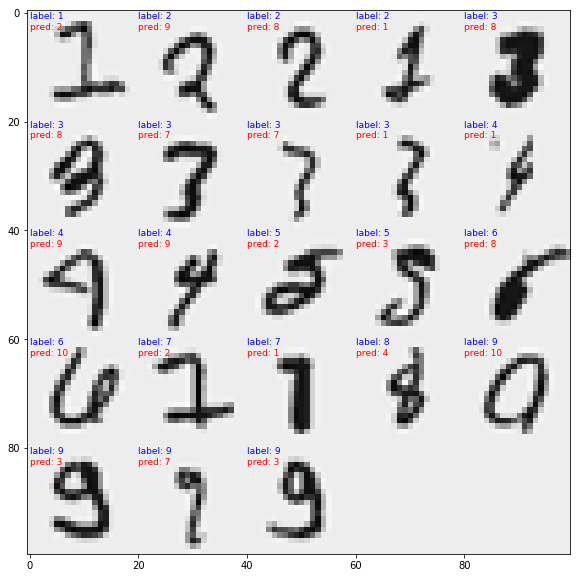

In [116]:
width, height = 20, 20
ncols = 5
nrows = 1 + len(false_idx)//5

digits_im = np.zeros((height*nrows, width*ncols))
plt.figure(figsize=(10,10))
for i in np.arange(len(false_idx)):
    x_coord, y_coord = i%ncols * width, i//ncols * height
    digits_im[y_coord:y_coord+height, x_coord:x_coord+width] = X[false_idx[i]].reshape(height, width).T
    
plt.imshow(digits_im, cmap=plt.cm.gray_r)
for i in np.arange(len(false_idx)):
    x_coord, y_coord = i%ncols * width, i//ncols * height
    idx = false_idx[i]
    text = 'label: {}'.format(y.flatten()[idx])
    plt.text(x_coord, y_coord+1, text, fontsize=9, color='b',);
    text = 'pred: {}'.format(y_pred[idx])
    plt.text(x_coord, y_coord+3, text, fontsize=9, color='r',);